In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Datos
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [2]:
#df = pd.read_csv('./Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
#df.index.freq = 'MS'
#df.columns = ['Sales']


#df = pd.read_csv('./quantity_monthly_3dmovil.csv',index_col='DATE',parse_dates=True)
#df.index = pd.date_range('2018-03-01', periods=36, freq="MS")
#df.columns = ['quantity']

df = pd.read_csv('./quantity_daily_3dmovil.csv',index_col='DATE',parse_dates=True)
#df['purchase-date'] = df.index.strftime('%Y-%m-%d')
#df.set_index("purchase-date", inplace = True)
#df.index = pd.to_datetime(df.index,format='%Y-%m-%d')
df.index = pd.date_range('2018-03-31', periods=1039, freq="D")
#df.index = pd.date_range('2018-03-01', periods=36, freq="MS")
#pd.date_range("2018-01-01", periods=3, freq="H")
#df.index
#df.index.freq = 'D'
df.columns = ['quantity']
#df['quantity']=df.quantity.diff(1)


In [3]:
df.head()

,quantity
2018-03-31,1
2018-04-01,1
2018-04-02,2
2018-04-03,2
2018-04-04,1


<AxesSubplot:>

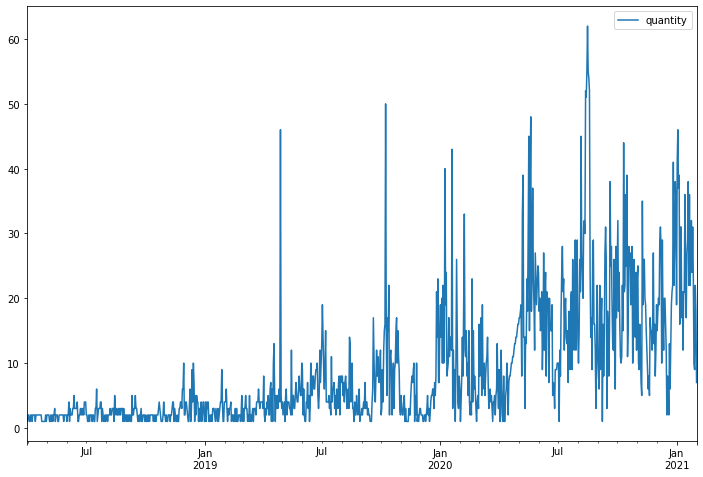

In [4]:
df.plot(figsize=(12,8))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:>

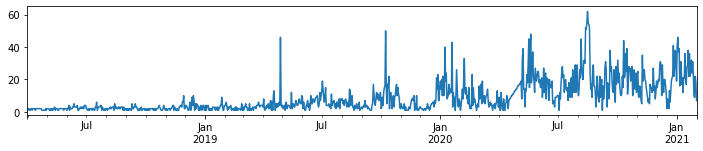

In [6]:
results = seasonal_decompose(df['quantity'])
results.observed.plot(figsize=(12,2))

<AxesSubplot:>

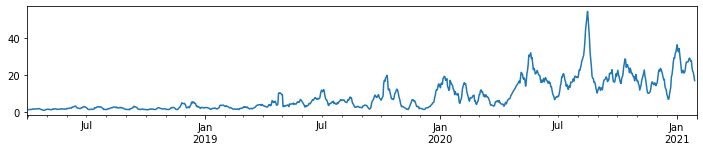

In [7]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:>

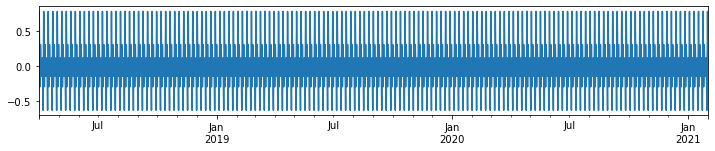

In [8]:
results.seasonal.plot(figsize=(12,2))

<AxesSubplot:>

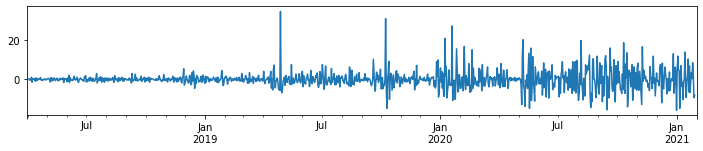

In [9]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [10]:
len(df)

1039

In [11]:
len(df)-28

1011

In [12]:
train = df.iloc[:len(df)-28]
test = df.iloc[len(df)-28:]

In [13]:
len(test)

28

## Escalando los datos

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)

MinMaxScaler()

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

Este generador toma una secuencia de puntos de datos (como una sereie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.

#### Argumentos
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
scaled_train

array([[0.        ],
       [0.        ],
       [0.01639344],
       ...,
       [0.6557377 ],
       [0.73770492],
       [0.59016393]])

In [20]:
# Definimos el generator
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)#definimos los batches

In [21]:
len(scaled_train)

1011

In [22]:
len(generator) # n_input = 2

1004

In [23]:
scaled_train[:5]

array([[0.        ],
       [0.        ],
       [0.01639344],
       [0.01639344],
       [0.        ]])

In [24]:
# ¿Cómo luce el primer batch?
generator[0]

(array([[[0.        ],
         [0.        ],
         [0.01639344],
         [0.01639344],
         [0.        ],
         [0.        ],
         [0.01639344]]]),
 array([[0.01639344]]))

In [25]:
X,y = generator[0]

In [26]:
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')
#cada batch constara de dos datos o 2 primeros meses y la prediccion sera el tercer mes

Datos: 
[0.         0.         0.01639344 0.01639344 0.         0.
 0.01639344]
Predicción: 
 [[0.01639344]]


In [27]:
# Vamos a redefinir para que utilice 12 meses y luego prediga el próximo mes
#n_input = 12
#generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [28]:
# ¿Cómo luce el primer batch?
#X,y = generator[0]

In [603]:
#print(f'Given the Array: \n{X.flatten()}')
#print(f'Predict this y: \n {y}')

### Creando el Modelo

In [29]:
from keras.models import Sequential#Modelo secuencial
from keras.layers import Dense#capa densa
from keras.layers import Dropout
from keras.layers import LSTM#capa lstm
from tensorflow.math import reduce_prod

In [162]:
# define model
#print(n_input)
model = Sequential()#creamos un modelo secuencial
#funcion de activacion relu y especificamos la dimension de entrada
#model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))#la primera capa que se añade sera de tipo LSTM con 100 neuronas
       
model.add(LSTM(200, activation='linear', input_shape=(n_input, n_features), return_sequences = True))
model.add(LSTM(200, input_shape=(n_input, n_features), return_sequences = True))
model.add(LSTM(200, input_shape=(n_input, n_features)))
#model.add(Dropout(0.2))
#model.add(Dense(1))
model.add(Dense(1))#le añadimos una capa densa que agrega todas las neuronas del LSTM a una sola prendiccion es decir una prediccion
#model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])#se compila utilizando como perdida el MSE y como optimizador ADAM
#model.compile(optimizer='rmsprop', loss='mse')
model.compile(optimizer='rmsprop', loss='mse')

In [163]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 7, 200)            161600    
_________________________________________________________________
lstm_29 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
lstm_30 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [164]:
# fit model
model.fit_generator(generator,epochs=70)#una carrera completa a traves de los datos de entrenamiento

Epoch 1/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0149
Epoch 2/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0122
Epoch 3/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0115
Epoch 4/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0112
Epoch 5/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0104
Epoch 6/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0111
Epoch 7/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0103
Epoch 8/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0108
Epoch 9/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0108
Epoch 10/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0106
Epoch 11/70
1004/1004 [==============================] - 17s 17ms/step - loss: 0.0103
Epoch 12/70
1004/1004 [==============================] - 17s 17

In [165]:
model.history.history.keys()

dict_keys(['loss'])

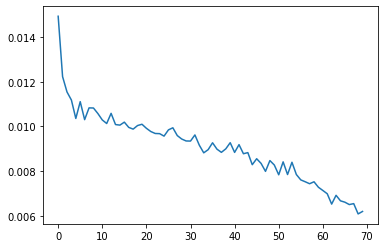

In [166]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluando en los Datos de Prueba (Test)

In [167]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
first_eval_batch = scaled_train[-28:]

In [168]:
first_eval_batch

array([[0.44262295],
       [0.14754098],
       [0.45901639],
       [0.24590164],
       [0.18032787],
       [0.31147541],
       [0.31147541],
       [0.24590164],
       [0.18032787],
       [0.01639344],
       [0.1147541 ],
       [0.09836066],
       [0.01639344],
       [0.19672131],
       [0.08196721],
       [0.18032787],
       [0.29508197],
       [0.32786885],
       [0.3442623 ],
       [0.6557377 ],
       [0.3442623 ],
       [0.42622951],
       [0.60655738],
       [0.55737705],
       [0.29508197],
       [0.6557377 ],
       [0.73770492],
       [0.59016393]])

In [169]:
X.shape

(1, 7, 1)

In [170]:
first_eval_batch = first_eval_batch.reshape((1, 28, n_features))

In [171]:
first_eval_batch.shape

(1, 28, 1)

In [172]:
model.predict(first_eval_batch)#el primer valor predicho

array([[0.2280838]], dtype=float32)

In [173]:
scaled_test

array([[0.62295082],
       [0.24590164],
       [0.49180328],
       [0.49180328],
       [0.26229508],
       [0.32786885],
       [0.18032787],
       [0.32786885],
       [0.32786885],
       [0.57377049],
       [0.32786885],
       [0.26229508],
       [0.42622951],
       [0.45901639],
       [0.60655738],
       [0.3442623 ],
       [0.57377049],
       [0.3442623 ],
       [0.40983607],
       [0.50819672],
       [0.37704918],
       [0.49180328],
       [0.36065574],
       [0.14754098],
       [0.13114754],
       [0.3442623 ],
       [0.27868852],
       [0.09836066]])

Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.
----

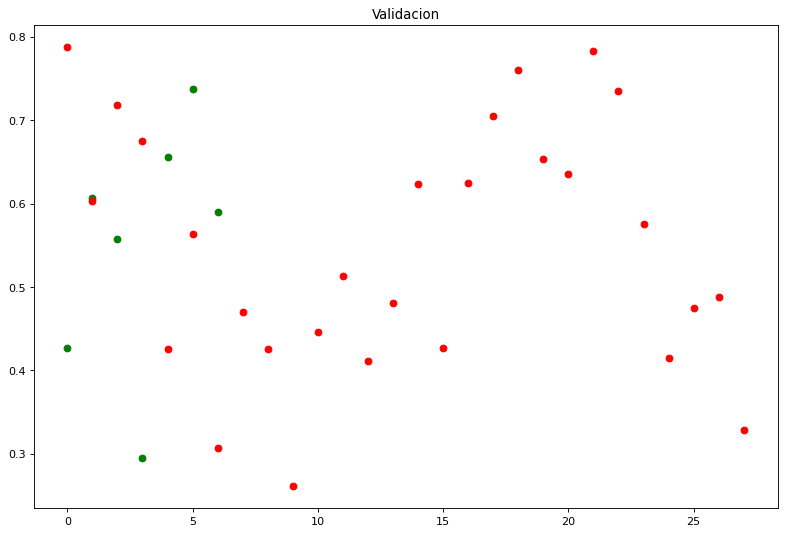

[[17.77332968]
 [27.93244219]
 [18.50757995]
 [19.10603544]
 [29.42040926]
 [15.96054369]
 [20.98420915]
 [23.1579529 ]
 [12.38797745]
 [15.15483649]
 [15.7949892 ]
 [15.20283106]
 [16.09622031]
 [16.23183604]
 [12.17558278]
 [16.14739083]
 [16.63934857]
 [12.37284127]
 [15.73940654]
 [17.29519647]
 [12.70345032]
 [17.23412091]
 [19.00046211]
 [12.94034085]
 [19.74312583]
 [22.54054174]
 [13.59805942]
 [19.86633319]]


<AxesSubplot:>

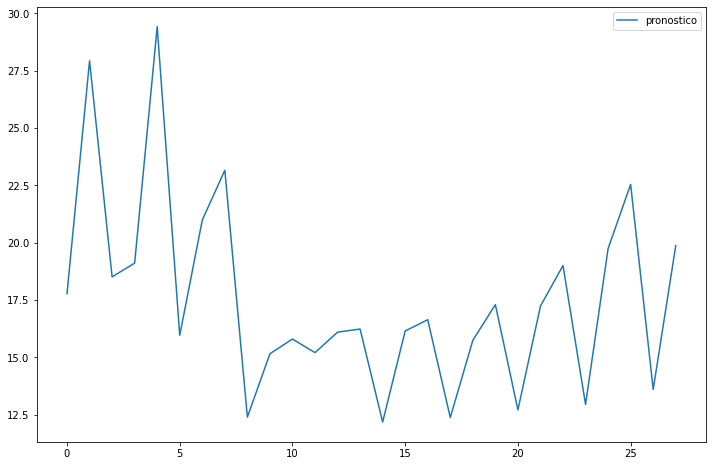

In [174]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    # guardar la predicción
    test_predictions.append(current_pred) 
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

plt.figure(figsize=(12, 8), dpi=80)
plt.scatter(range(len(first_eval_batch)),first_eval_batch,c='g')
plt.scatter(range(len(test_predictions)),test_predictions,c='r')
plt.title('Validacion')
plt.show()
#est.plot(figsize=(12,8))
#En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. 
#Cuanto más cerca ó superpuestos mejor. TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más.

#generator2 = TimeseriesGenerator(scaled_test, scaled_test, length=11, batch_size=1)
#history = model.fit_generator(generator,epochs=20,validation_data=generator2)

#loss_per_epoch = model.history.history['loss']
#plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

#plt.plot(model.history.history['loss'])
#plt.title('loss')
#plt.plot(history.history['val_loss'])
#plt.title('validate loss')
#plt.show()

test_predictions2 = []
first_eval_batch2 = scaled_train[-n_input:]
current_batch2 = first_eval_batch2.reshape((1, n_input, n_features))
for p in range(28):
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred2 = model.predict(current_batch)[0]
    # guardar la predicción
    test_predictions2.append(current_pred2) 
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred2]],axis=1)

test_predictions2
#print(test_predictions2)
true_predictions2 = scaler.inverse_transform(test_predictions2)
print(true_predictions2)

prediccion1SemanaDiciembre = pd.DataFrame(true_predictions2)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot(figsize=(12,8))


In [175]:
test_predictions

[array([0.78780466], dtype=float32),
 array([0.60301846], dtype=float32),
 array([0.7177533], dtype=float32),
 array([0.6752049], dtype=float32),
 array([0.4259618], dtype=float32),
 array([0.56299794], dtype=float32),
 array([0.3073643], dtype=float32),
 array([0.47043186], dtype=float32),
 array([0.4260661], dtype=float32),
 array([0.26088136], dtype=float32),
 array([0.44598192], dtype=float32),
 array([0.51295424], dtype=float32),
 array([0.41134202], dtype=float32),
 array([0.48068887], dtype=float32),
 array([0.62395644], dtype=float32),
 array([0.42676967], dtype=float32),
 array([0.6252395], dtype=float32),
 array([0.7047077], dtype=float32),
 array([0.76011455], dtype=float32),
 array([0.6535954], dtype=float32),
 array([0.6358535], dtype=float32),
 array([0.78281564], dtype=float32),
 array([0.7351268], dtype=float32),
 array([0.57497156], dtype=float32),
 array([0.41516504], dtype=float32),
 array([0.47525868], dtype=float32),
 array([0.48797923], dtype=float32),
 array([0.3

In [176]:
scaled_test

array([[0.62295082],
       [0.24590164],
       [0.49180328],
       [0.49180328],
       [0.26229508],
       [0.32786885],
       [0.18032787],
       [0.32786885],
       [0.32786885],
       [0.57377049],
       [0.32786885],
       [0.26229508],
       [0.42622951],
       [0.45901639],
       [0.60655738],
       [0.3442623 ],
       [0.57377049],
       [0.3442623 ],
       [0.40983607],
       [0.50819672],
       [0.37704918],
       [0.49180328],
       [0.36065574],
       [0.14754098],
       [0.13114754],
       [0.3442623 ],
       [0.27868852],
       [0.09836066]])

## Transformación inversa y Comparación

In [177]:
true_predictions = scaler.inverse_transform(test_predictions)

In [178]:
true_predictions

array([[49.05608445],
       [37.78412622],
       [44.78295076],
       [42.18749726],
       [26.98366934],
       [35.34287417],
       [19.7492232 ],
       [29.69634372],
       [26.99003214],
       [16.91376323],
       [28.20489711],
       [32.29020834],
       [26.09186351],
       [30.32202107],
       [39.06134295],
       [27.0329501 ],
       [39.13960898],
       [43.98716861],
       [47.36698759],
       [40.86931866],
       [39.78706527],
       [48.75175375],
       [45.8427344 ],
       [36.07326496],
       [26.32506725],
       [29.99077937],
       [30.76673323],
       [21.01786652]])

In [179]:
import matplotlib.pyplot as plt
#import tensorflow as tf
#import pydot,graphviz
#from IPython.display import SVG

#test

#plt.plot(model.history.history['accuracy'])
#plt.plot(model.history.history['loss']) 
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'])

#import tensorflow as tf
#early_stopping = tf.keras.callbacks.EarlyStopping(
#    monitor="val_loss", patience=5, restore_best_weights=True
#)

#generator2 = TimeseriesGenerator(scaled_test, scaled_test, length=11, batch_size=1)#definimos los batches
#history = model.fit_generator(generator,epochs=20,validation_data=(generator2))

#def visualize_loss(history, title):
#    loss = history.history["loss"]
#    val_loss = history.history["val_loss"]
#    epochs = range(len(loss))
#    plt.figure()
#    plt.plot(epochs, loss, "b", label="Training loss")
#    plt.plot(epochs, val_loss, "r", label="Validation loss")
#    plt.title(title)
#    plt.xlabel("Epochs")
#    plt.ylabel("Loss")
#    plt.legend()
#    plt.show()


#visualize_loss(history, "Training and Validation Loss")
#model.fit(
#    generator,
#    epochs=50,
#    callbacks=[early_stopping],
#)
#history.resid
#tf.keras.utils.model_to_dot(
#    model,
#    show_shapes=True,
    #show_dtype=False,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=False,
    #dpi=96,
    #subgraph=False,
#).create(prog='dot',format='svg')

model.evaluate(generator,verbose=1)

1004/1004 [==============================] - 3s 3ms/step - loss: 0.0058


0.005764561705291271

In [180]:
#test
test['Predictions'] = true_predictions

<ipython-input-180-f4e01b1b9de7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [181]:
test

,quantity,Predictions
2021-01-05,39,49.056084
2021-01-06,16,37.784126
2021-01-07,31,44.782951
2021-01-08,31,42.187497
2021-01-09,17,26.983669
2021-01-10,21,35.342874
2021-01-11,12,19.749223
2021-01-12,21,29.696344
2021-01-13,21,26.990032
2021-01-14,36,16.913763


<AxesSubplot:>

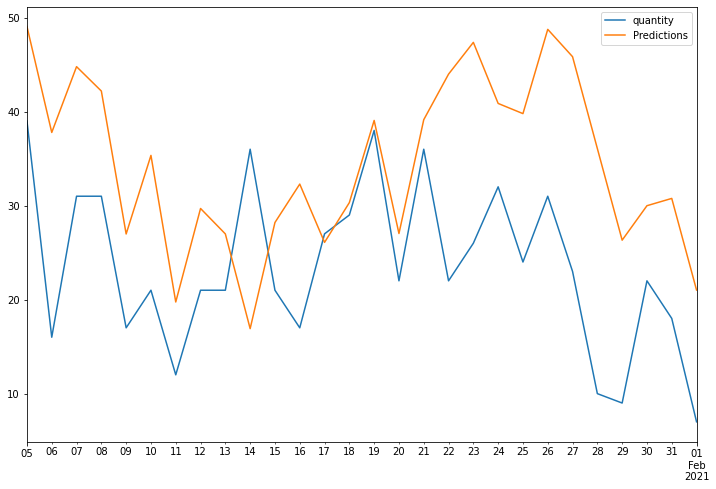

In [182]:
test.plot(figsize=(12,8))

# Guardar un Modelo

In [183]:
model.save('m5_sequential_140921.h5')

# Cargar un Modelo

In [548]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [549]:
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
